<a href="https://colab.research.google.com/github/davetew/Modern-Aerospace-Propulsion/blob/main/Thermodynamics_of_Gases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Thermodynamics of Gases
This notebook uses [Cantera](https://cantera.org/) and the GRI 30 mechanism to calculate the specific heats of several gases to illustrate their variation with temperature.

In [43]:
# Quietly install Cantera -- a non-standard Colab package
%pip install -q cantera

In [55]:
# Import the required python packages
import numpy as np
import cantera as ct
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina' # Mac retina display resolution for plots

import pandas as pd

## Specific Heats
Calculate and plot the specific heats of various gases as functions of temperature.

In [76]:
# Create a Cantera solution object using the GRI 3.0 mechanism
gas = ct.Solution('gri30.yaml')
gas.basis = "molar"

# Species
species = ['H2', 'Ar', 'O2', 'CO2', 'CH4']

# Temperatures @ which the specific heat is to be calculated
temperatures_K = np.linspace(300, 2000, 500)


In [77]:
# Calculate the enthalpy and internal energy for each gas at each temperature
enthalpy = pd.DataFrame(index=temperatures_K, columns=species)
cp = pd.DataFrame(index=temperatures_K, columns=species)

internal_energy = pd.DataFrame(index=temperatures_K, columns=species)
cv = pd.DataFrame(index=temperatures_K, columns=species)

for s in species:
  for t in temperatures_K:
      gas.TPX = t, ct.one_atm, {s: 1}
      enthalpy.loc[t, s] = gas.h
      cp.loc[t, s] = gas.cp
      internal_energy.loc[t, s] = gas.u
      cv.loc[t, s] = gas.cv


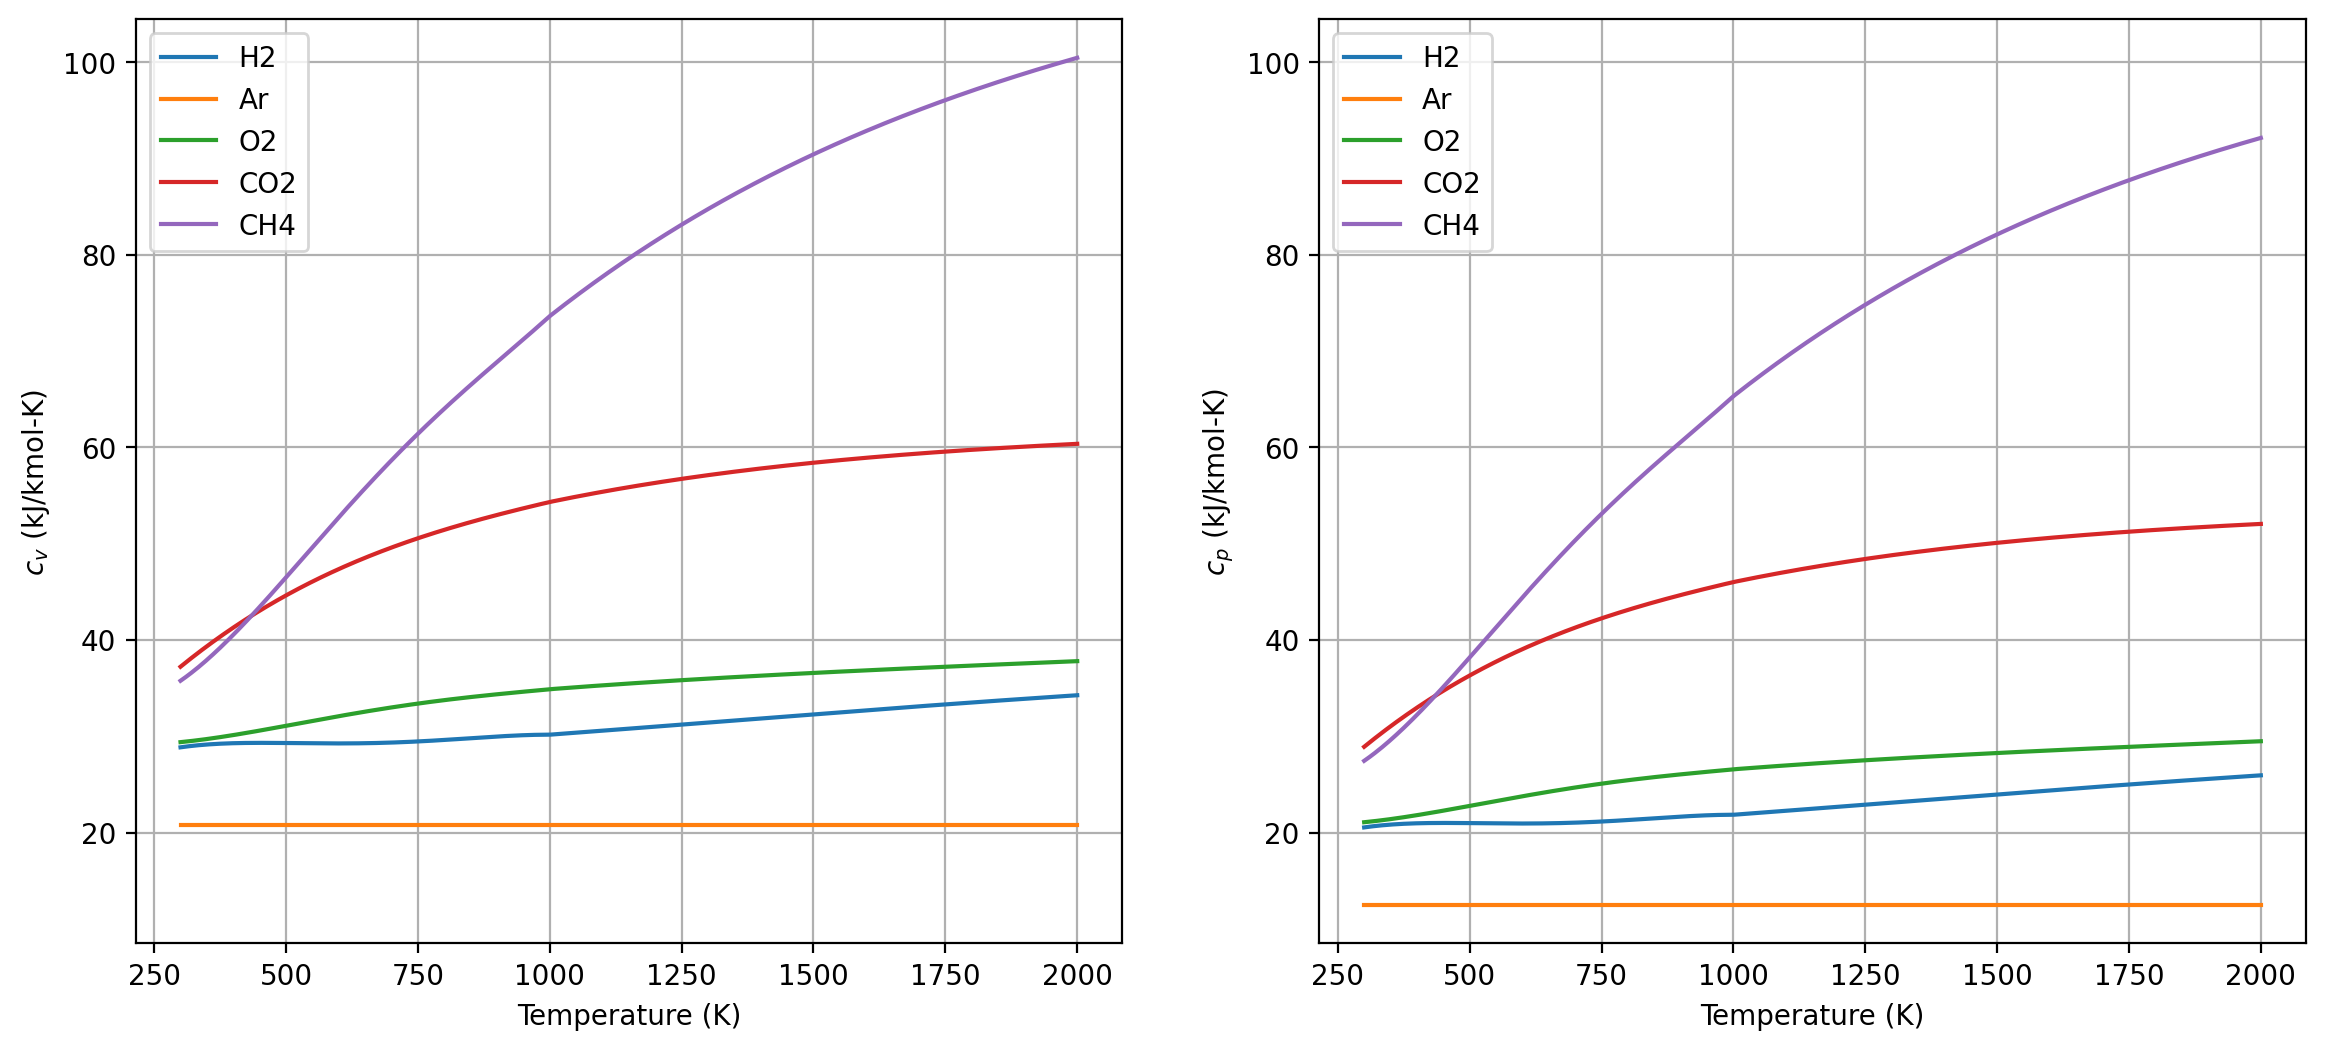

In [80]:
# Plot the specific heats vs temperature
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for s in species:
    ax[0].plot(cv.index, cp[s]/1000, label=s)
    ax[1].plot(cp.index, cv[s]/1000, label=s)

# Set the same y-axis scale for both charts - using the appropriate minimum and maximum
max_lim = max(ax[0].get_ylim()[1], ax[1].get_ylim()[1])
min_lim = min(ax[0].get_ylim()[0], ax[1].get_ylim()[0])
ax[0].set_ylim(min_lim, max_lim)
ax[1].set_ylim(min_lim, max_lim)
ax[0].set_xlabel('Temperature (K)')
ax[0].set_ylabel('$c_v$ (kJ/kmol-K)')
ax[1].set_xlabel('Temperature (K)')
ax[1].set_ylabel('$c_p$ (kJ/kmol-K)')
ax[0].legend(); ax[0].grid()
ax[1].legend(); ax[1].grid()
plt.show()